In [1]:
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from neuralnet import *

In [2]:
X_train, y_train = load_data('data/MNIST_train.pkl')
X_valid, y_valid = load_data('data/MNIST_valid.pkl')
X_test, y_test = load_data('data/MNIST_test.pkl')

In [3]:
def visualize(train, validation, title, loss=True):
    keyword = 'Loss'
    if not loss:
        keyword = 'Accuracy'
    epoch = range(len(train))
    plt.plot(epoch, train, label="Train {}".format(keyword))
    plt.plot(epoch, validation, label = "Validation {}".format(keyword))
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(keyword)
    plt.legend()
    plt.show()

### e) Experiments with activations

In [4]:
def default_config():
    config = {}
    config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
    config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
    config['batch_size'] = 256  # Number of training samples per batch to be passed to network
    config['epochs'] = 100  # Number of epochs to train the model
    config['early_stop'] = True  # Implement early stopping or not
    config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
    config['L2_penalty'] = 0  # Regularization constant
    config['momentum'] = True  # Denotes if momentum is to be applied or not
    config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
    config['learning_rate'] = 0.05 # Learning rate of gradient descent algorithm
    return config

#### i. Sigmoid activation

In [5]:
sigmoid_conf = default_config()
sigmoid_conf['activation'] = 'sigmoid'
sigmoid_net = Neuralnetwork(sigmoid_conf)

In [6]:
sigmoid_train_stats = trainer(sigmoid_net, X_train, y_train, X_valid, y_valid, sigmoid_conf, False)

------- Model Config: 
Activation: sigmoid 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


In [7]:
print("test accuracy for sigmoid activation: ", test(sigmoid_net, X_test, y_test, sigmoid_conf))

test accuracy for sigmoid activation:  0.9271


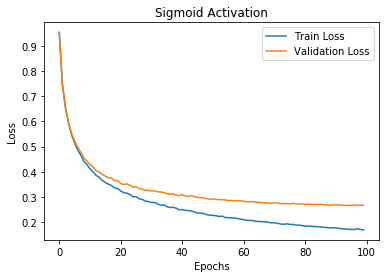

In [8]:
visualize(sigmoid_train_stats['train_losses'], sigmoid_train_stats['valid_losses'], "Sigmoid Activation")

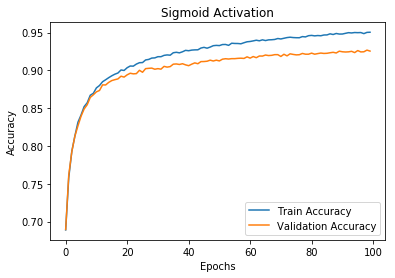

In [9]:
visualize(sigmoid_train_stats['train_accuracies'], sigmoid_train_stats['valid_accuracies'], "Sigmoid Activation", False)

#### ii. ReLU activation

In [10]:
relu_conf = default_config()
relu_conf['activation'] = 'ReLU'
relu_net = Neuralnetwork(relu_conf)

In [11]:
relu_train_stats = trainer(relu_net, X_train, y_train, X_valid, y_valid, relu_conf)

------- Model Config: 
Activation: ReLU 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Epoch 0 - loss train: 2.299486 loss validation: 2.301110 accuracy train: 0.112920 accuracy validation: 0.113700
Epoch 1 - loss train: 2.283063 loss validation: 2.280464 accuracy train: 0.123500 accuracy validation: 0.125300
Epoch 2 - loss train: 2.134919 loss validation: 2.129761 accuracy train: 0.195520 accuracy validation: 0.200700
Epoch 3 - loss train: 2.033547 loss validation: 2.041324 accuracy train: 0.249080 accuracy validation: 0.252600
Epoch 4 - loss train: 1.908430 loss validation: 1.910159 accuracy train: 0.296420 accuracy validation: 0.303300
Epoch 5 - loss train: 1.842436 loss validation: 1.839595 accuracy train: 0.332360 accuracy validation: 0.340500
Epoch 6 - loss train: 1.848992 loss validation: 1.831811 accuracy train: 0.322440 accuracy validation: 0.332200
Epoch 7 - loss train: 1.841277 loss validation: 1.849805 accuracy train: 0.320420 accuracy validation: 0.324800
Epoch 8 - loss train: 1.581463 loss validation: 1.570852 accuracy train: 0.397000 accuracy validation: 0

Epoch 73 - loss train: 0.694554 loss validation: 0.714550 accuracy train: 0.788320 accuracy validation: 0.783400
Epoch 74 - loss train: 0.682992 loss validation: 0.702476 accuracy train: 0.796340 accuracy validation: 0.791300
Epoch 75 - loss train: 0.740644 loss validation: 0.757173 accuracy train: 0.782080 accuracy validation: 0.783100
Epoch 76 - loss train: 0.709682 loss validation: 0.729078 accuracy train: 0.783880 accuracy validation: 0.779200
Epoch 77 - loss train: 0.728371 loss validation: 0.744843 accuracy train: 0.788160 accuracy validation: 0.787200
Epoch 78 - loss train: 0.668258 loss validation: 0.680363 accuracy train: 0.801360 accuracy validation: 0.797400
Epoch 79 - loss train: 0.723990 loss validation: 0.747638 accuracy train: 0.786060 accuracy validation: 0.786500
Epoch 80 - loss train: 0.700648 loss validation: 0.717617 accuracy train: 0.784520 accuracy validation: 0.781000
Epoch 81 - loss train: 0.728269 loss validation: 0.753251 accuracy train: 0.781560 accuracy vali

In [12]:
print("test accuracy for ReLU activation: ", test(relu_net, X_test, y_test, relu_conf))

test accuracy for ReLU activation:  0.7939


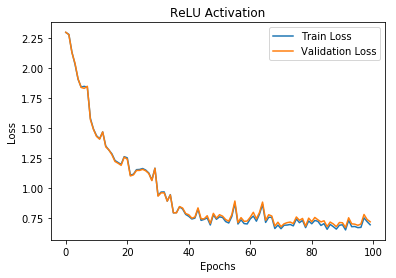

In [13]:
visualize(relu_train_stats['train_losses'], relu_train_stats['valid_losses'], "ReLU Activation")

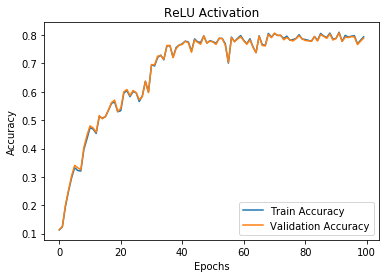

In [14]:
visualize(relu_train_stats['train_accuracies'], relu_train_stats['valid_accuracies'], "ReLU Activation", False)

In [15]:
relu_conf2 = default_config()
relu_conf2['activation'] = 'ReLU'
relu_conf2['layer_specs'] = [784, 100, 10]
relu_conf2['learning_rate'] = 0.008
relu_net2 = Neuralnetwork(relu_conf2)

In [16]:
relu_train_stats2 = trainer(relu_net2, X_train, y_train, X_valid, y_valid, relu_conf2, False)

------- Model Config: 
Activation: ReLU 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.008 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


/Users/ntemiyasathit/Documents/CSE253/PA2-Backprop/neuralnet.py:212: RuntimeWarning: divide by zero encountered in log
  output = -(targets * np.log(logits)).sum()/len(targets)
/Users/ntemiyasathit/Documents/CSE253/PA2-Backprop/neuralnet.py:212: RuntimeWarning: invalid value encountered in multiply
  output = -(targets * np.log(logits)).sum()/len(targets)


In [17]:
print("test accuracy for ReLU activation (conf 2): ", test(relu_net2, X_test, y_test, relu_conf2))

test accuracy for ReLU activation (conf 2):  0.913


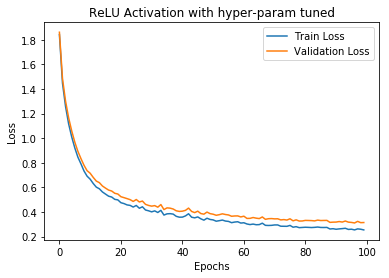

In [18]:
visualize(relu_train_stats2['train_losses'], relu_train_stats2['valid_losses'], "ReLU Activation with hyper-param tuned")

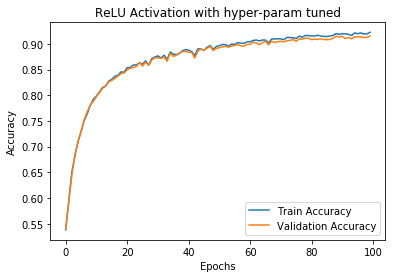

In [ ]:
visualize(relu_train_stats2['train_accuracies'], relu_train_stats2['valid_accuracies'], "ReLU Activation with hyper-param tuned", False)

### f) Experiments with network topology

#### i. Half and double hidden units

In [ ]:
half_conf = default_config()
half_conf['layer_specs'] = [784, 25, 10]
half_net = Neuralnetwork(half_conf)

In [ ]:
half_train_stats = trainer(half_net, X_train, y_train, X_valid, y_valid, half_conf, False)

------- Model Config: 
Activation: tanh 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


In [ ]:
print("test accuracy for half hidden units: ", test(half_net, X_test, y_test, half_conf))

In [ ]:
visualize(half_train_stats['train_losses'], half_train_stats['valid_losses'], "Half Units in Hidden Layer")

In [ ]:
visualize(half_train_stats['train_accuracies'], half_train_stats['valid_accuracies'], "Half Units in Hidden Layer", False)

In [ ]:
double_conf1 = default_config()
double_conf1['layer_specs'] = [784, 100, 10]
double_net1 = Neuralnetwork(double_conf1)
d_train_stats = trainer(double_net1, X_train, y_train, X_valid, y_valid, double_conf1, False)

In [ ]:
print("test accuracy for double hidden units: ", test(double_net1, X_test, y_test, double_conf1))

In [ ]:
double_conf = default_config()
double_conf['layer_specs'] = [784, 400, 10]
double_net = Neuralnetwork(double_conf)

In [ ]:
double_train_stats = trainer(double_net, X_train, y_train, X_valid, y_valid, double_conf, False)

In [ ]:
print("test accuracy for double hidden units: ", test(double_net, X_test, y_test, double_conf))

In [ ]:
visualize(doublt_train_stats['train_losses'], doublt_train_stats['valid_losses'], "Double Units in Hidden Layer")

In [ ]:
visualize(double_train_stats['train_accuracies'], double_train_stats['valid_accuracies'], "Double Units in Hidden Layer", False)

#### ii. More hidden units

In [ ]:
new_conf = default_config()
new_conf['layer_specs'] = [784, 50, 50, 10]
new_net = Neuralnetwork(new_conf)

In [ ]:
new_train_stats = trainer(new_net, X_train, y_train, X_valid, y_valid, new_conf, False)

In [ ]:
print("test accuracy for 2 hidden layers: ", test(new_net, X_test, y_test, new_conf))

In [ ]:
visualize(new_train_stats['train_losses'], new_train_stats['valid_losses'], "Two Hidden Layers")

In [ ]:
visualize(new_train_stats['train_accuracies'], new_train_stats['valid_accuracies'], "Two Hidden Layers", False)

In [ ]:
three_conf = default_config()
three_conf['layer_specs'] = [784, 50, 50, 50, 10]
three_conf['learning_rate'] = 0.035
three_net = Neuralnetwork(three_conf)

In [ ]:
three_train_stats = trainer(three_net, X_train, y_train, X_valid, y_valid, three_conf, False)

In [ ]:
print("test accuracy for 2 hidden layers: ", test(three_net, X_test, y_test, three_conf))

In [ ]:
visualize(three_train_stats['train_losses'], three_train_stats['valid_losses'], "Three Hidden Layers")

In [ ]:
visualize(three_train_stats['train_accuracies'], three_train_stats['valid_accuracies'], "Three Hidden Layers", False)